In [1]:
from utils import HouseholdDataLoader, TSF_Data

dataload = HouseholdDataLoader()
data = dataload.data_by_days

tsf = TSF_Data(data=data['Global_active_power'],
               input_width=21,
               output_width=7)

tsf.normalize_data()

2022-06-14 17:10:52.948701: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, LSTM
from keras import Sequential
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tcn import TCN

input_width = tsf.data_train[0].shape[1]
num_features = 1

inputs = Input(shape=(input_width, num_features))


def model_builder(hp):
    kernel_size = hp.Choice('kernel_size', values=[2, 3, 5, 7])
    nb_filters = hp.Choice('nb_filters', values=[16, 32, 64,128])
    use_skip_connections = hp.Choice(
        'use_skip_connections', values=[True, False])

    use_batch_norm = hp.Choice(
        'use_batch_norm', values=[True, False])

    def temp(x): return 2**x
    def dilation_gen(x): return list(map(temp, range(x)))
    dilations = hp.Choice('dilations', values=list(range(2, 8)))
    nb_stacks = hp.Choice('nb_stacks', values=[1, 2, 3, 4, 5])
    nb_units_lstm = hp.Int('units_LSTM', min_value=32, max_value=320, step=32)

    x1 = TCN(input_shape=(input_width, 1),
             kernel_size=kernel_size,
             nb_filters=nb_filters,
             dilations=dilation_gen(dilations),
             use_skip_connections=use_skip_connections,
             use_batch_norm=use_batch_norm,
             use_weight_norm=False,
             use_layer_norm=False,
             return_sequences=True
             )(inputs)

    x2 = LSTM(nb_units_lstm)(x1)

    x3 = Dense(units=tsf.data_train[1].shape[1])(x2)

    model_searching = Model(inputs, x3)

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_searching.summary()

    model_searching.compile(loss=tf.keras.losses.Huber(),
                            optimizer='adam',
                            metrics=['mse'])

    return model_searching

In [3]:
import keras_tuner as kt
import os

exp_path = "HouseHold_TCN_Tune/Bayesian/"
tuning_path = exp_path + "/models"
if os.path.isdir(tuning_path):
    # x = input("Path is existed, Delete and do tuning?")
    # if x=='Y':
    import shutil

    shutil.rmtree(tuning_path)

print("[INFO] instantiating a random search tuner object...")

tuner = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=50,
    seed=42,
    directory=tuning_path)

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


import sys
orig_stdout = sys.stdout
f = open('seaching_process_log.txt', 'w')
sys.stdout = f

tuner.search(tsf.data_train[0], tsf.data_train[1],
             validation_data=tsf.data_valid,
             callbacks=[tf.keras.callbacks.TensorBoard(exp_path + "/log")],
             epochs=10)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

sys.stdout = orig_stdout
f.close()


INFO:tensorflow:Oracle triggered exit


In [9]:
print(f"""
kernel_size {best_hps.get('kernel_size')},  and
nb_filters: {best_hps.get('nb_filters')}, 
dilations: {best_hps.get('dilations')}
units_LSTM: {best_hps.get('units_LSTM')}
use_skip_connections: {best_hps.get('use_skip_connections')}
""")


kernel_size 3,  and
nb_filters: 64, 
dilations: 7
units_LSTM: 32
use_skip_connections: 1



In [8]:

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_best = tuner.hypermodel.build(best_hps)


print('Train...')

callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
]

history = model_best.fit(x=tsf.data_train[0],
                         y=tsf.data_train[1],
                         validation_data=tsf.data_valid,
                         epochs=100,
                         callbacks=[callbacks],
                         verbose=2,
                         use_multiprocessing=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 1)]           0         
                                                                 
 tcn_1 (TCN)                 (None, 21, 128)           648576    
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 669,415
Trainable params: 665,831
Non-trainable params: 3,584
_________________________________________________________________
Train...
Epoch 1/100
40/40 - 5s - loss: 0.0173 - mse: 0.0347 - val_loss: 0.0116 - val_mse: 0.0232 - lr: 0.0010 - 5s/epoch - 137ms/step
Epoch 2/100
40/40 - 1s - loss: 0.0082 - mse: 0

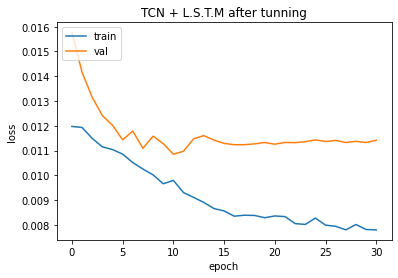

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['mse'][5:])
plt.plot(history.history['val_mse'][5:])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('TCN + L.S.T.M after tunning')
plt.show()